In [9]:
#import modules
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
from pkg_resources import non_empty_lines
import os
import glob
from matplotlib.lines import Line2D

In [120]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/'
ctd_dir = data_dir + 'ctd_data/'
rapid_cast_dir = data_dir + 'RapidCast/'


# Find all NetCDF files
files = glob.glob(os.path.join(ctd_dir, 'in2026_v01_*', 'in2026_v01_*.nc'))

# Sort numerically by station number
files = sorted(files, key=lambda f: int(os.path.basename(f).split('_')[-1].split('.')[0]))

datasets = {}
stations_all = []

for file_name in files:
    stn = os.path.basename(file_name).split('_')[-1].split('.')[0]
    stations_all.append(stn)
    datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)
    print(f"Opened dataset for station {stn}")

wave_ctd_stations = ['018','019', '020', '021', '022', '023'] #sediment waves
wave_rapid_stations = ['003', '004', '005']


Opened dataset for station 001
Opened dataset for station 002
Opened dataset for station 003
Opened dataset for station 004
Opened dataset for station 005
Opened dataset for station 006
Opened dataset for station 007
Opened dataset for station 008
Opened dataset for station 009
Opened dataset for station 010
Opened dataset for station 011
Opened dataset for station 012
Opened dataset for station 013
Opened dataset for station 014
Opened dataset for station 015
Opened dataset for station 016
Opened dataset for station 017
Opened dataset for station 018
Opened dataset for station 019
Opened dataset for station 020
Opened dataset for station 021
Opened dataset for station 022
Opened dataset for station 023
Opened dataset for station 024


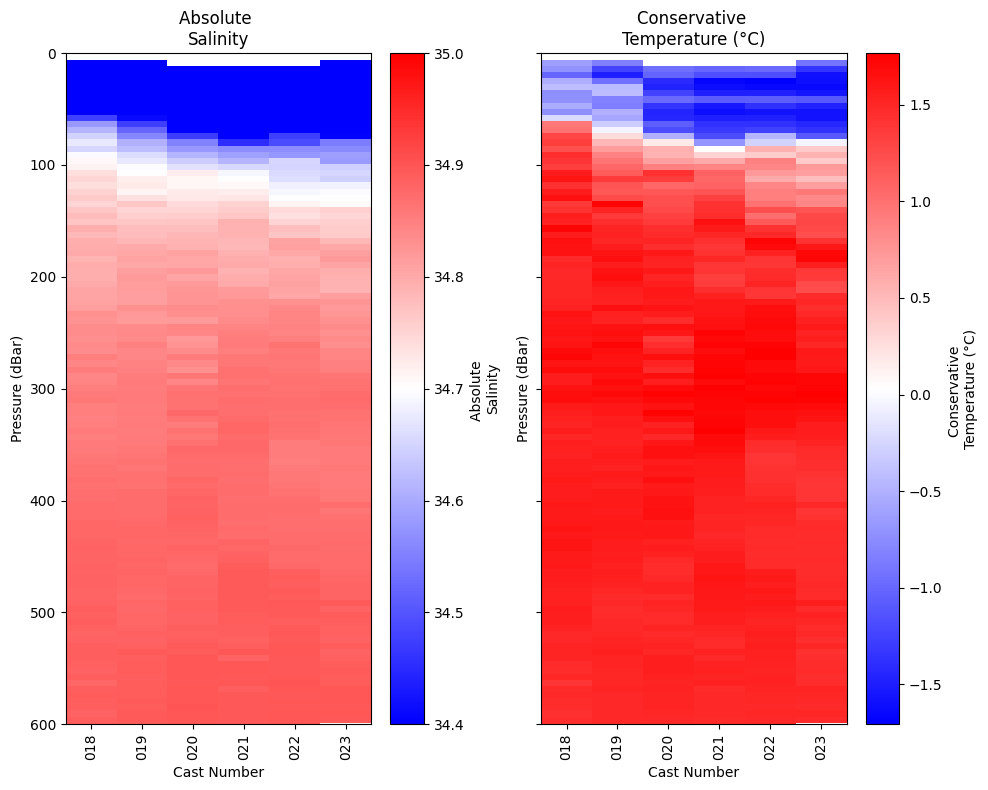

In [121]:
pressures = []
temps = []
sals = []
conds = []
fluro = []
rho0 = []



y_min = 0
y_max = 600

for stn in wave_ctd_stations:
    ds = datasets[stn]

    # --- Extract variables ---
    p = ds.prDM.values
    # t = ds.t090C.values
    # s = ds.sal00.values
    t = ds.CT.values
    s = ds.SA.values
    c = ds.c0Sperm.values
    f = ds.flECO_AFL.values
    rho_anom = ds.sigma0.values

    # --- Mask to in-water (pressure > 8.5 dbar) ---
    mask = p > 8.5
    p = p[mask]
    t = t[mask]
    s = s[mask]
    c = c[mask]
    f = f[mask]
    rho_anom = rho_anom[mask]

    # --- Sort by pressure (increasing) ---
    order = np.argsort(p)
    p = p[order]
    t = t[order]
    s = s[order]
    c = c[order]
    f = f[order]
    rho_anom = rho_anom[order]

    # --- Append to lists ---
    pressures.append(p)
    temps.append(t)
    sals.append(s)
    conds.append(c)
    fluro.append(f)
    rho0.append(rho_anom)

p_min = min(p[0] for p in pressures)
p_max = max(p[-1] for p in pressures)
p_grid = np.linspace(p_min, p_max, 600)

temp_grid = np.vstack([
    np.interp(p_grid, pressures[i], temps[i], left=np.nan, right=np.nan)
    for i in range(len(wave_ctd_stations))
])

sal_grid = np.vstack([
    np.interp(p_grid, pressures[i], sals[i], left=np.nan, right=np.nan)
    for i in range(len(wave_ctd_stations))
])

cond_grid = np.vstack([
    np.interp(p_grid, pressures[i], conds[i], left=np.nan, right=np.nan)
    for i in range(len(wave_ctd_stations))
])

fluro_grid = np.vstack([
    np.interp(p_grid, pressures[i], fluro[i], left=np.nan, right=np.nan)
    for i in range(len(wave_ctd_stations))
])

rho0_grid = np.vstack([
    np.interp(p_grid, pressures[i], rho0[i], left=np.nan, right=np.nan)
    for i in range(len(wave_ctd_stations))
])

# # x: station index
x = np.arange(len(wave_ctd_stations))
x_edges = np.arange(len(wave_ctd_stations) + 1)

# y: pressure edges
p_edges = np.zeros(len(p_grid) + 1)
p_edges[1:-1] = (p_grid[:-1] + p_grid[1:]) / 2
p_edges[0] = p_grid[0] - (p_grid[1] - p_grid[0]) / 2
p_edges[-1] = p_grid[-1] + (p_grid[-1] - p_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(10,8), sharey=True)

variables = [
    (sal_grid,  "Absolute \nSalinity",        "bwr", 34.4, 35),

    (temp_grid, "Conservative \nTemperature (°C)", "bwr", np.nanmin(temp_grid), np.nanmax(temp_grid)),

]


for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        p_edges,
        var2d.T,        # shape must be (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    # Set station numbers as x-ticks
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(wave_ctd_stations)
    ax.tick_params(axis='x', labelrotation=90)

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Cast Number")
    ax.set_ylabel("Pressure (dBar)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


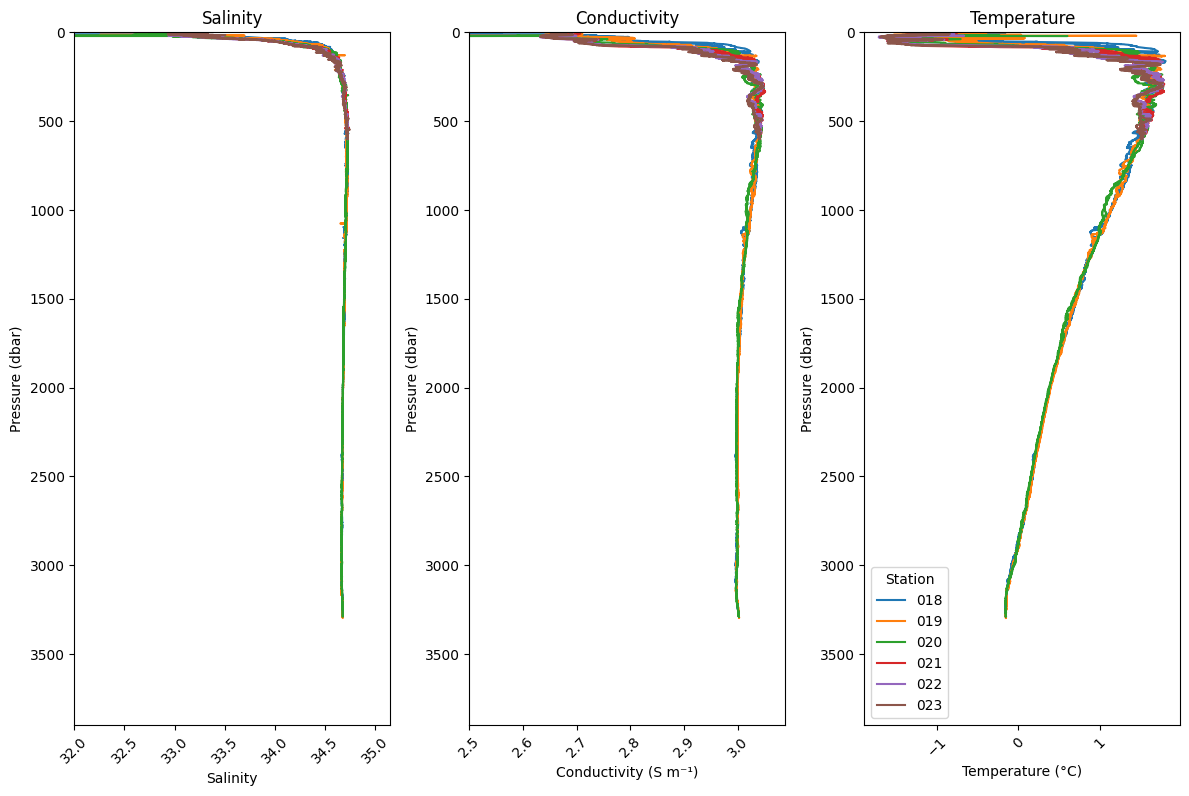

In [122]:
y_min = 0
y_max = 3900

start = None
end = None
sl = slice(start, end)

# Consistent color per station
colors = plt.cm.tab10.colors
station_colors = {
    stn: colors[i % len(colors)]
    for i, stn in enumerate(wave_ctd_stations)
}

xlims = {
    'sal00': (32, None),
    'c0Sperm': (2.5, None )
    # 't090C': (-2.5, 1.0),

}


# Variables to plot: (data_key, title, x-label)
variables = [
    ('sal00', 'Salinity', 'Salinity'),
    ('c0Sperm', 'Conductivity', 'Conductivity (S m⁻¹)'),
    ('t090C', 'Temperature', 'Temperature (°C)')
    # ('flECO_AFL', 'Fluorescence', 'flECO_AFL'),
    # ('prDM', 'Pressure', 'Pressure (dbar)'),
    # ('longitude', 'Longitude', 'Longitude (°)'),
    # ('latitude', 'Latitude', 'Latitude (°)'),
    # ('density', 'Density', 'Density (kg m⁻³)'),
    # ('sigma0', 'Density Anomaly', 'σ₀ (kg m⁻³)')
]

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
axs = ax.flatten()

for (var, title, xlabel), ax in zip(variables, axs):

    for stn in wave_ctd_stations:
        data = datasets[stn]

        pressure = data.prDM.values
        x = getattr(data, var).values

        # Mask shallow data
        mask = pressure > 8.5
        pressure = pressure[mask]
        x = x[mask]

        ax.plot(
            x[sl],
            pressure[sl],
            color=station_colors[stn],
            label=stn,
            linewidth=1.5
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Pressure (dbar)')
    ax.set_ylim(y_min, y_max)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelrotation=45)

    if var in xlims and xlims[var] is not None:
        ax.set_xlim(xlims[var])

axs[-1].legend(title='Station', loc='lower left')
plt.tight_layout()
plt.show()


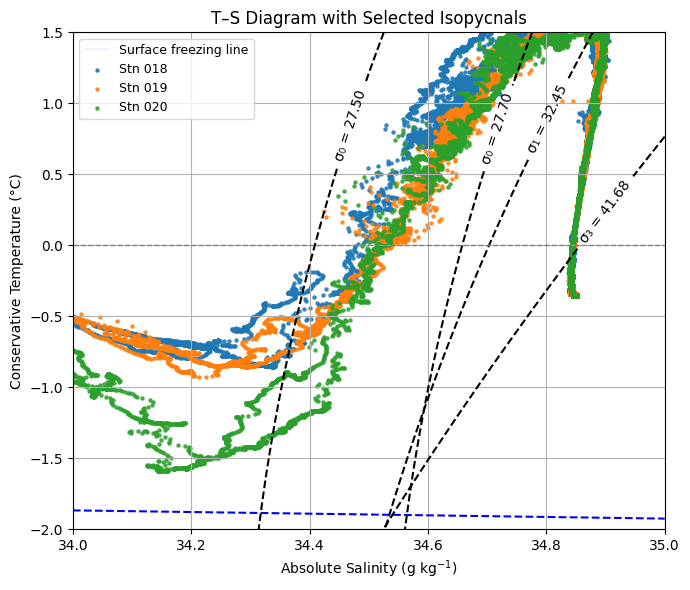

In [129]:
xmin, xmax = 34, 35
ymin, ymax = -2.0, 1.5

# Density grid
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

surface_fp = -1.9
pd_0 = [27.50, 27.70]   # sigma-0 contours
pd_1 = [32.45]         # sigma-1 contour
pd_3 = [41.68]         # sigma-3 contour

# Compute density fields
sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))

# Sigma-0 contours
cs0 = ax.contour(
    Sg, Tg, sigma0_grid,
    levels=pd_0,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs0, fmt='σ₀ = %.2f')

# Sigma-1 contour
cs1 = ax.contour(
    Sg, Tg, sigma1_grid,
    levels=pd_1,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs1, fmt='σ₁ = %.2f')

# Sigma-3 contour
cs3 = ax.contour(
    Sg, Tg, sigma3_grid,
    levels=pd_3,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs3, fmt='σ₃ = %.2f')

# Freezing line (surface)
ax.plot(
    s_grid,
    gsw.CT_freezing(s_grid, 0, 10),  # ~10 dbar surface
    color='blue',
    linewidth=1.5,
    linestyle='--',
    # label='Surface freezing line'
)

# CTD casts
for i, stn in enumerate(wave_ctd_stations[0:3]):
    ax.scatter(
        sals[i], temps[i],
        s=5,
        alpha=0.8,
        label=f'Stn {stn}'
    )


ax.axhline(0, color='grey', linestyle='--', linewidth=1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title('T–S Diagram with Selected Isopycnals')


legend_elements = [
    Line2D(
        [0], [0],
        color='blue',
        linestyle='--',
        linewidth=0.1,
        label='Surface freezing line'
    )
]

handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=legend_elements + handles,
    labels=[h.get_label() for h in legend_elements] + labels,
    loc='best',
    fontsize=9,
    frameon=True
)


ax.grid(True)

plt.tight_layout()
plt.show()


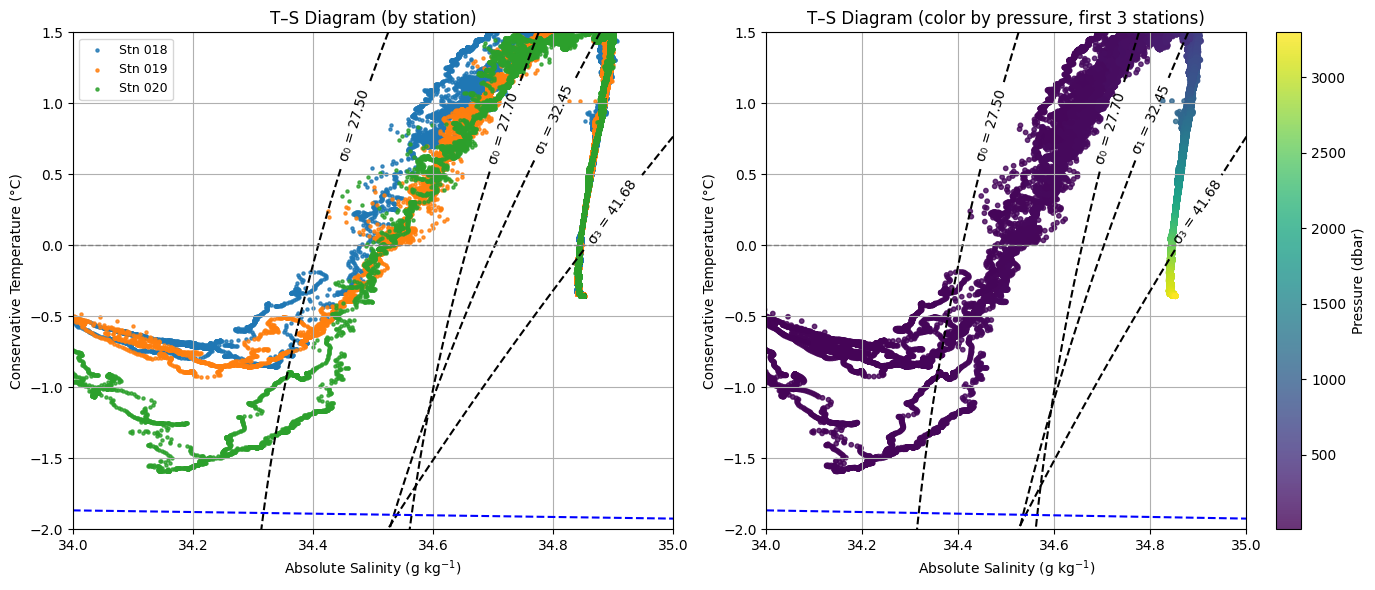

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gsw

# --- T–S diagram grid ---
xmin, xmax = 34, 35
ymin, ymax = -2.0, 1.5

s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

# --- Isopycnal levels ---
pd_0 = [27.50, 27.70]   # sigma-0
pd_1 = [32.45]           # sigma-1
pd_3 = [41.68]           # sigma-3

# --- Compute density fields ---
sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # two subplots side by side

# -----------------------------
# First subplot: color by station
# -----------------------------
ax = axs[0]

# Sigma contours with labels
cs0 = ax.contour(Sg, Tg, sigma0_grid, levels=pd_0, colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs0, fmt='σ₀ = %.2f')
cs1 = ax.contour(Sg, Tg, sigma1_grid, levels=pd_1, colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs1, fmt='σ₁ = %.2f')
cs3 = ax.contour(Sg, Tg, sigma3_grid, levels=pd_3, colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs3, fmt='σ₃ = %.2f')

# Freezing line
ax.plot(s_grid, gsw.CT_freezing(s_grid, 0, 10), color='blue', linewidth=1.5, linestyle='--')

# Scatter by station (first 3)
for i, stn in enumerate(wave_ctd_stations[0:3]):
    ax.scatter(sals[i], temps[i], s=5, alpha=0.8, label=f'Stn {stn}')

ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title('T–S Diagram (by station)')
ax.grid(True)
ax.legend(fontsize=9, frameon=True)

# -----------------------------
# Second subplot: color by pressure
# -----------------------------
ax2 = axs[1]

# Sigma contours with labels
cs0 = ax2.contour(Sg, Tg, sigma0_grid, levels=pd_0, colors='black', linestyles='--', linewidths=1.5)
ax2.clabel(cs0, fmt='σ₀ = %.2f')
cs1 = ax2.contour(Sg, Tg, sigma1_grid, levels=pd_1, colors='black', linestyles='--', linewidths=1.5)
ax2.clabel(cs1, fmt='σ₁ = %.2f')
cs3 = ax2.contour(Sg, Tg, sigma3_grid, levels=pd_3, colors='black', linestyles='--', linewidths=1.5)
ax2.clabel(cs3, fmt='σ₃ = %.2f')

# Freezing line
ax2.plot(s_grid, gsw.CT_freezing(s_grid, 0, 10), color='blue', linewidth=1.5, linestyle='--')

# Flatten first 3 stations for scatter
sals_flat = np.concatenate(sals[0:3])
temps_flat = np.concatenate(temps[0:3])
pressures_flat = np.concatenate(pressures[0:3])

sc = ax2.scatter(
    sals_flat,
    temps_flat,
    c=pressures_flat,
    cmap='viridis',
    s=10,
    alpha=0.8
)
cbar = plt.colorbar(sc, ax=ax2, label='Pressure (dbar)')

ax2.axhline(0, color='grey', linestyle='--', linewidth=1)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax2.set_ylabel('Conservative Temperature (°C)')
ax2.set_title('T–S Diagram (color by pressure, first 3 stations)')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [98]:
def read_vp2(filepath):
    header = {}
    data_start = None

    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            line = line.strip()

            if line == '[DATA]':
                data_start = i + 3  # skip column names + units
                break

            if '=' in line and not line.startswith('['):
                key, val = line.split('=', 1)
                header[key.strip()] = val.strip()

    df = pd.read_csv(
        filepath,
        sep='\t',
        skiprows=data_start,
        header=None  # first row is actual data
    )

    # Manually assign column names from the COLUMNS section
    df.columns = ['DateTime', 'Depth', 'Pressure', 'Temperature',
                  'Conductivity', 'Salinity', 'SoundVelocity', 'Density', 'Ticks']

    return header, df


In [99]:
class VP2Dataset:
    def __init__(self, header, df):
        self.prDM = df['Pressure'].values
        self.t090C = df['Temperature'].values
        self.sal00 = df['Salinity'].values
        self.c0Sperm = df['Conductivity'].values
        self.density = df['Density'].values

In [100]:
vp2_datasets = {}

for stn in wave_rapid_stations:
    # find the vp2 file that matches this station
    vp2_file = next(
        f for f in os.listdir(rapid_cast_dir)
        if stn in f and f.lower().endswith('.vp2')
    )

    filepath = os.path.join(rapid_cast_dir, vp2_file)

    header, df = read_vp2(filepath)
    vp2_datasets[stn] = VP2Dataset(header, df)

    print(f'Loaded VP2 station {stn}')


Loaded VP2 station 003
Loaded VP2 station 004
Loaded VP2 station 005


In [101]:
header, df = read_vp2(os.path.join(rapid_cast_dir, vp2_file))

# Convert Salinity units
df['Salinity'] = df['Salinity'] * 100

vp2_datasets[stn] = df

print('converted mS/cm to mS/m to match CTD data')


converted mS/cm to mS/m to match CTD data


converted mS/cm to mS/m to match CTD data
converted mS/cm to mS/m to match CTD data
converted mS/cm to mS/m to match CTD data


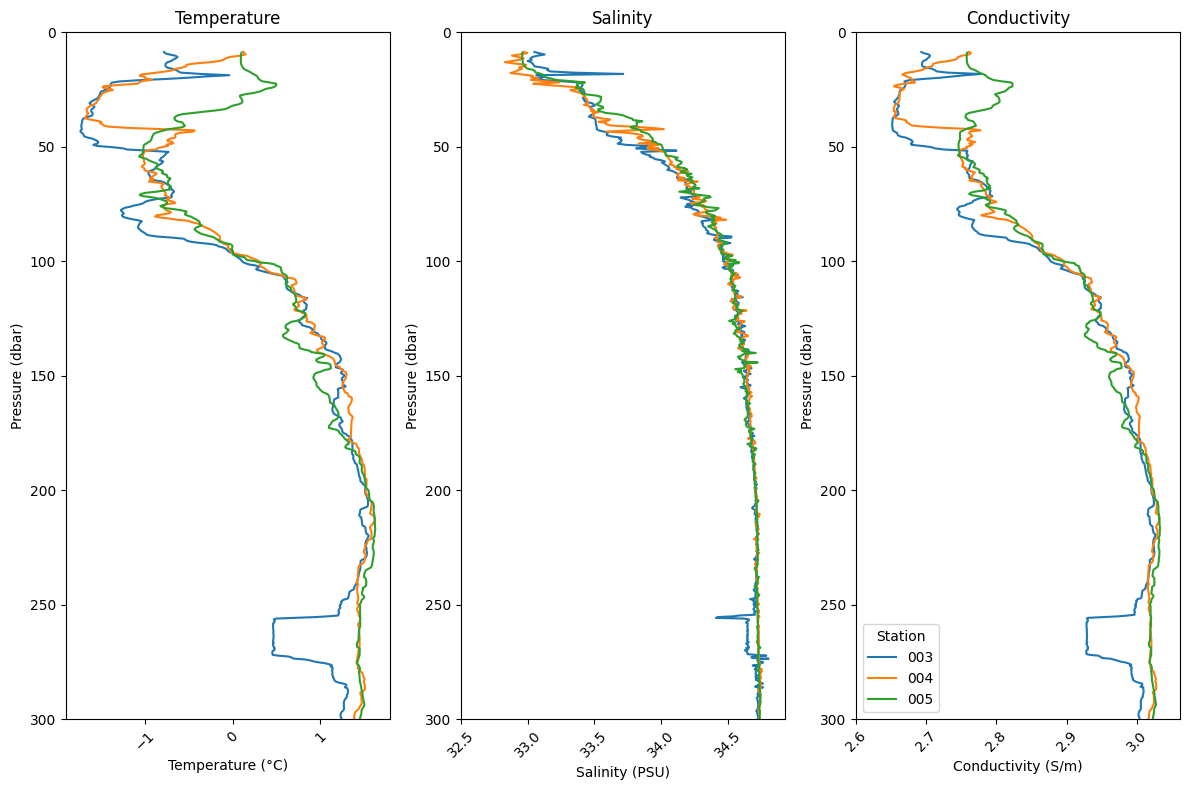

In [102]:
# Color map for stations
colors = plt.cm.tab10.colors
station_colors = {stn: colors[i % len(colors)] for i, stn in enumerate(wave_rapid_stations)}

# Variables to plot: (DataFrame column, plot title, x-label)
variables = [
    ('Temperature', 'Temperature', 'Temperature (°C)'),
    ('Salinity', 'Salinity', 'Salinity (PSU)'),
    ('Conductivity', 'Conductivity', 'Conductivity (S/m)'),
    # ('Density', 'Density', 'Density (kg/m³)'),

]

# Optional: manual x-limits
xlims = {
    'Salinity': (32.5, None),
    'Conductivity': (2.6, None),
}

# Load all stations into dict
vp2_datasets = {}
for stn in wave_rapid_stations:
    vp2_file = next(f for f in os.listdir(rapid_cast_dir) if stn in f and f.lower().endswith('.vp2'))
    header, df = read_vp2(os.path.join(rapid_cast_dir, vp2_file))
    # Convert Salinity units
    df['Conductivity'] = df['Conductivity'] * 0.1
    vp2_datasets[stn] = df
    print('converted mS/cm to mS/m to match CTD data')


fig, ax = plt.subplots(1, 3, figsize=(12, 8))
axs = ax.flatten()

for (col, title, xlabel), ax in zip(variables, axs):

    for stn in wave_rapid_stations:
        data = vp2_datasets[stn]
        mask = data['Pressure'] > 8.5  # optional shallow filter
        ax.plot(
            data[col][mask],
            data['Pressure'][mask],
            color=station_colors[stn],
            label=stn,
            linewidth=1.5
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Pressure (dbar)')
    ax.set_ylim(y_min, y_max)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelrotation=45)

    if title in xlims:
        ax.set_xlim(xlims[title])

ax.legend(title='Station', loc='lower left')
plt.tight_layout()
plt.show()


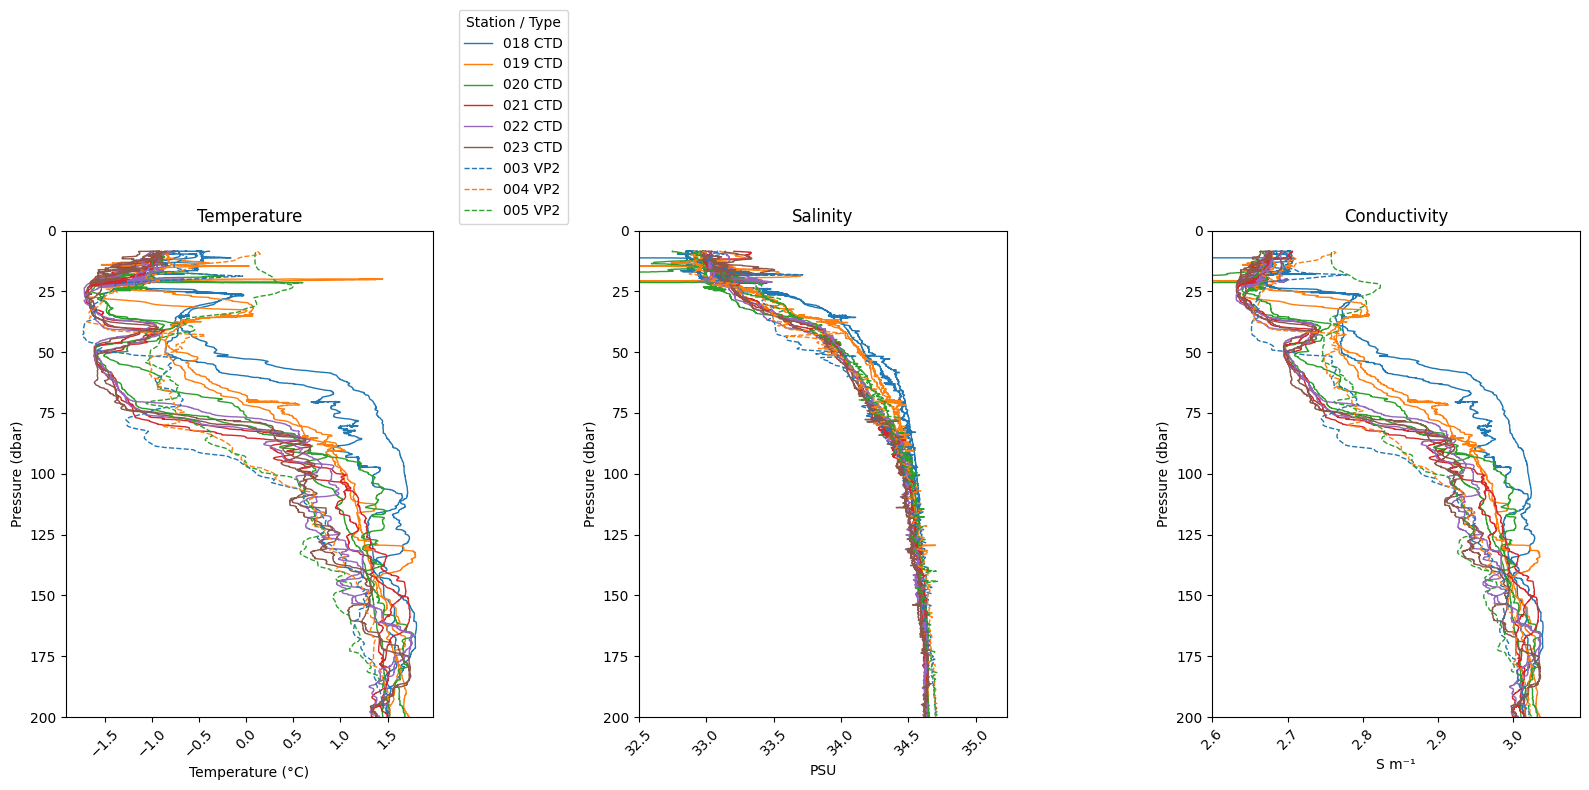

In [103]:
y_min = 0
y_max = 200
start = None
end = None
sl = slice(start, end)

# Consistent colors
colors = plt.cm.tab10.colors
ctd_colors = {stn: colors[i % len(colors)] for i, stn in enumerate(wave_ctd_stations)}
vp2_colors = {stn: colors[i % len(colors)] for i, stn in enumerate(wave_rapid_stations)}

# Variables to plot: (CTD attr name, VP2 column name, title, units/xlabel)
variables = [
    ('t090C', 'Temperature', 'Temperature', 'Temperature (°C)'),
    ('sal00', 'Salinity', 'Salinity', 'PSU'),
    ('c0Sperm', 'Conductivity', 'Conductivity', 'S m⁻¹'),
]

# Optional manual x-limits
xlims = {
    'Salinity': (32.5, None),
    'Conductivity': (2.6, None),
}

fig, ax = plt.subplots(1, len(variables), figsize=(16, 8))
axs = ax.flatten()

for (ctd_var, vp2_col, title, xlabel), ax in zip(variables, axs):

    # --- Plot CTD stations ---
    for stn in wave_ctd_stations:
        data = datasets[stn]
        pressure = data.prDM.values
        x = getattr(data, ctd_var).values

        mask = pressure > 8.5
        pressure = pressure[mask]
        x = x[mask]

        ax.plot(
            x[sl],
            pressure[sl],
            color=ctd_colors[stn],
            linestyle='-',  # solid for CTD
            linewidth=1,
            label=f'{stn} CTD'
        )

    # --- Plot VP2 stations ---
    for stn in wave_rapid_stations:
        data = vp2_datasets[stn]
        mask = data['Pressure'] > 8.5

        ax.plot(
            data[vp2_col][mask],
            data['Pressure'][mask],
            color=vp2_colors[stn],
            linestyle='--',  # dashed for VP2
            linewidth=1,
            label=f'{stn} VP2'
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Pressure (dbar)')
    ax.set_ylim(y_min, y_max)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelrotation=45)

    if title in xlims:
        ax.set_xlim(xlims[title])

# Shared legend for all stations
axs[0].legend(title='Station / Type', bbox_to_anchor=(1.05, 1), loc='lower left')
plt.tight_layout()
plt.show()


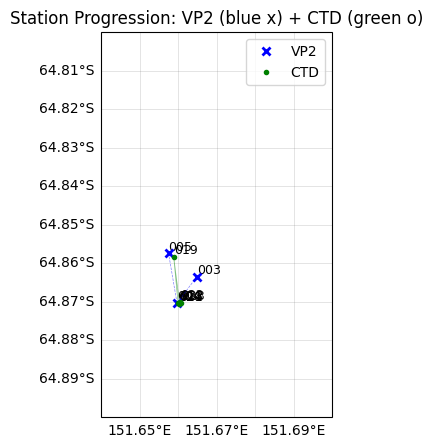

In [104]:
# -----------------------------
# Fixed lon/lat for rapid casts
# -----------------------------
vp2_coords = {
    '003': (151.6648, -64.8636),
    '004': (151.6597, -64.8704),
    '005': (151.6575, -64.8575),
}

# -----------------------------
# CTD mean lon/lat from data
# -----------------------------
mean_lon = []
mean_lat = []
stations_all = []

# VP2 stations: use fixed coords
for stn in vp2_coords:
    lon, lat = vp2_coords[stn]
    mean_lon.append(lon)
    mean_lat.append(lat)
    stations_all.append(stn)

# CTD stations: compute from dataset
for stn in wave_ctd_stations:
    ds = datasets[stn]
    lon = ds.longitude.values
    lat = ds.latitude.values
    pressure = ds.prDM.values

    mask = pressure > 8.5  # shallow filter
    lon_masked = lon[mask]
    lat_masked = lat[mask]

    mean_lon.append(np.mean(lon_masked))
    mean_lat.append(np.mean(lat_masked))
    stations_all.append(stn)

mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)
stations_all = np.array(stations_all)

# -----------------------------
# Plot map
# -----------------------------
proj = ccrs.PlateCarree()
lon_min, lon_max = 151.64, 151.70
lat_min, lat_max = -64.9, -64.8
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=proj)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax.coastlines(resolution='110m', linewidth=0.8)

# Filter stations inside extent
mask = (
    (mean_lat >= lat_min) & (mean_lat <= lat_max) &
    (mean_lon >= lon_min) & (mean_lon <= lon_max)
)
mean_lon_plot = mean_lon[mask]
mean_lat_plot = mean_lat[mask]
stations_plot = stations_all[mask]

# -----------------------------
# Plot lines connecting stations
# -----------------------------
# VP2: dashed blue
ax.plot(
    mean_lon_plot[:len(vp2_coords)],
    mean_lat_plot[:len(vp2_coords)],
    linestyle='--',
    color='blue',
    linewidth=0.5,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    zorder=4
)
# CTD: solid green
ax.plot(
    mean_lon_plot[len(vp2_coords):],
    mean_lat_plot[len(vp2_coords):],
    linestyle='-',
    color='green',
    linewidth=0.5,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# -----------------------------
# Plot markers
# -----------------------------
ax.plot(
    mean_lon_plot[:len(vp2_coords)],
    mean_lat_plot[:len(vp2_coords)],
    linestyle='None',
    marker='x',
    color='blue',
    markersize=6,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5,
    label='VP2'
)
ax.plot(
    mean_lon_plot[len(vp2_coords):],
    mean_lat_plot[len(vp2_coords):],
    linestyle='None',
    marker='o',
    color='green',
    markersize=2,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5,
    label='CTD'
)

# -----------------------------
# Label stations
# -----------------------------
for stn, lon, lat in zip(stations_plot, mean_lon_plot, mean_lat_plot):
    ax.text(
        lon, lat, stn,
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha='left',
        va='bottom'
    )

# -----------------------------
# Gridlines
# -----------------------------
lon_ticks = np.arange(-180, 181, 0.01)
lat_ticks = np.arange(-90, 91, 0.01)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='-',
    xlocs=lon_ticks,
    ylocs=lat_ticks
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title("Station Progression: VP2 (blue x) + CTD (green o)")
ax.legend(loc='upper right')
plt.show()


In [105]:
file_name = '2week_dot_all_30bmedian_egm2008_sig3.nc'
egm_2week_ds = xr.open_dataset(data_dir+file_name)

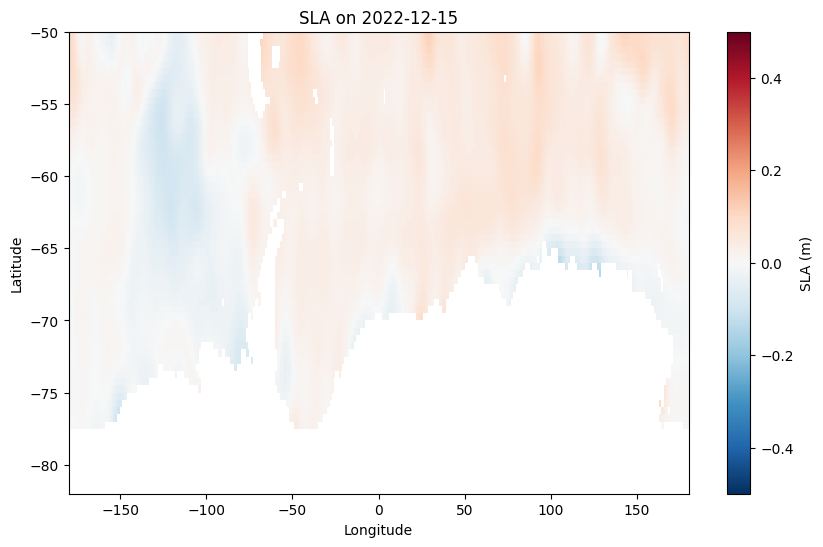

In [115]:
# target date
target = np.datetime64('2022-12-15')
# Find the closest available time
nearest_time = egm_2week_ds.time.sel(time=target, method='nearest')
# Extract SLA at that time
sla_2d = egm_2week_ds.sla.sel(time=nearest_time)

elat = egm_2week_ds.edge_lat.values
elon = egm_2week_ds.edge_lon.values

fig, ax = plt.subplots(figsize=(10,6))

pcm = ax.pcolormesh(
    elon,
    elat,
    sla_2d.T,  # transpose to match (lat, lon)
    shading='auto',
    cmap='RdBu_r',
    vmin=-0.5,
    vmax=0.5
)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f"SLA on {str(nearest_time.values)[:10]}")  # <- use nearest_time here

fig.colorbar(pcm, ax=ax, label='SLA (m)')
plt.show()



In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [13]:
ds = xr.open_dataset("/Users/iw2g24/PycharmProjects/COOKIES/Data/in2026_v01uwy.nc")
print(list(ds.keys()))

['historyIdent', 'historyDate', 'rawLatitude', 'latitude', 'latitudeQC', 'rawLongitude', 'longitude', 'longitudeQC', 'rawAlt', 'alt', 'altQC', 'rawSpeedOG', 'speedOG', 'speedOGQC', 'rawCourseOG', 'courseOG', 'courseOGQC', 'rawShipHeading', 'shipHeading', 'shipHeadingQC', 'rawDepth', 'depth', 'depthQC', 'longitudinalWaterSpeed', 'longitudinalWaterSpeedQC', 'transverseWaterSpeed', 'transverseWaterSpeedQC', 'longitudinalGroundSpeed', 'longitudinalGroundSpeedQC', 'transverseGroundSpeed', 'transverseGroundSpeedQC', 'lockOnWater', 'lockonGround', 'rawPortAirTemp', 'portAirTemp', 'portAirTempQC', 'rawPortHumidity', 'portHumidity', 'portHumidityQC', 'rawStbdAirTemp', 'stbdAirTemp', 'stbdAirTempQC', 'rawStbdHumidity', 'stbdHumidity', 'stbdHumidityQC', 'rawMaxWindGust', 'maxWindGust', 'maxWindGustQC', 'rawPortRelWindDir', 'portRelWindDir', 'portRelWindDirQC', 'rawPortRelWindSpeed', 'portRelWindSpeed', 'portRelWindSpeedQC', 'rawPortTrueWindDir', 'portTrueWindDir', 'portTrueWindDirQC', 'rawPortTru

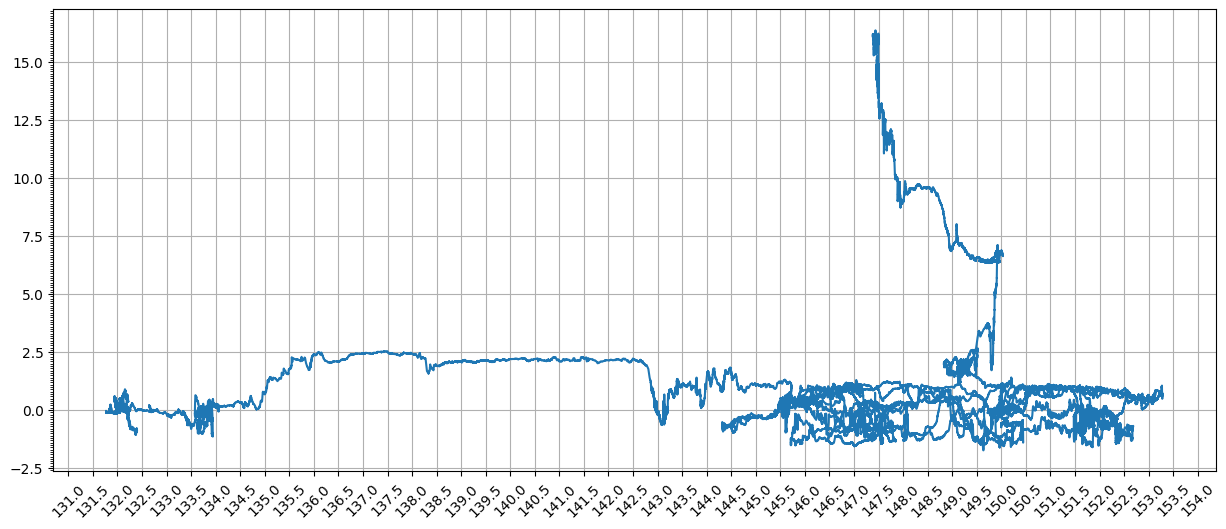

In [35]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_aspect('auto')
ax.plot(ds['longitude'].values, ds['waterTemp'].values)
# 3. Define the desired interval for major grid lines
# major_interval = 0.5
# major_locator = ticker.MultipleLocator(base=major_interval)
# ax.xaxis.set_major_locator(major_locator)
major_interval = 0.5
ax.xaxis.set_major_locator(ticker.MultipleLocator(major_interval))

plt.setp(ax.get_xticklabels(), rotation=45)



# Optional: Add minor grid lines with a different interval
minor_interval = 0.1
minor_locator = ticker.MultipleLocator(base=minor_interval)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='major')
# plt.grid(which='minor')